In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_model_data_in_time.csv")
data_df = data_df.drop(columns=['datetime'])
data_df

,depth,do,doc,poc,temp,volume,Air_Temperature_celsius,Shortwave_Radiation_Downwelling_wattPerMeterSquared,Longwave_Radiation_Downwelling_wattPerMeterSquared,Relative_Humidity_percent,Ten_Meter_Elevation_Wind_Speed_meterPerSecond,Precipitation_millimeterPerDay,Surface_Level_Barometric_Pressure_pascal,Cloud_Cover,dt,ea,day_of_year_list,time_of_day_list,ice,temp_obs,do_obs,doc_obs,poc_obs,secchi_obs
0,0.25,11.381491,5.803908,0.990601,15.027664,19925000.0,14.309991,93.727997,322.450012,64.306063,3.327762,0.0,98914.82031,1.000000,11923201,10.359133,138,18,0,NaN,NaN,NaN,NaN,NaN
1,0.75,11.381491,5.803908,0.990601,15.027664,18962500.0,14.309991,93.727997,322.450012,64.306063,3.327762,0.0,98914.82031,1.000000,11923201,10.359133,138,18,0,NaN,NaN,NaN,NaN,NaN
2,1.25,11.381491,5.803908,0.990601,15.027664,18000000.0,14.309991,93.727997,322.450012,64.306063,3.327762,0.0,98914.82031,1.000000,11923201,10.359133,138,18,0,NaN,NaN,NaN,NaN,NaN
3,1.75,11.381491,5.803908,0.990601,15.027664,17500000.0,14.309991,93.727997,322.450012,64.306063,3.327762,0.0,98914.82031,1.000000,11923201,10.359133,138,18,0,NaN,NaN,NaN,NaN,NaN
4,10.25,9.289158,5.736582,0.998232,11.075003,12000000.0,14.309991,93.727997,322.450012,64.306063,3.327762,0.0,98914.82031,1.000000,11923201,10.359133,138,18,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794185,7.75,11.257754,5.850379,0.603874,8.846719,13250000.0,21.459985,300.559998,342.149994,63.149491,4.378333,0.0,98641.21875,0.755736,169599601,15.977638,136,17,0,NaN,NaN,NaN,NaN,NaN
2794186,8.25,11.249851,5.848709,0.603260,8.777848,13000000.0,21.459985,300.559998,342.149994,63.149491,4.378333,0.0,98641.21875,0.755736,169599601,15.977638,136,17,0,NaN,NaN,NaN,NaN,NaN
2794187,8.75,11.243093,5.847564,0.602886,8.734047,12750000.0,21.459985,300.559998,342.149994,63.149491,4.378333,0.0,98641.21875,0.755736,169599601,15.977638,136,17,0,NaN,NaN,NaN,NaN,NaN
2794188,9.25,11.238053,5.846858,0.602664,8.709402,12500000.0,21.459985,300.559998,342.149994,63.149491,4.378333,0.0,98641.21875,0.755736,169599601,15.977638,136,17,0,NaN,NaN,NaN,NaN,NaN


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 111767
Number of training points: 1676500


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Overall Model

In [7]:
input_columns = ['depth', 'Air_Temperature_celsius', 'Shortwave_Radiation_Downwelling_wattPerMeterSquared',
                'Longwave_Radiation_Downwelling_wattPerMeterSquared','Relative_Humidity_percent', 
                 'Ten_Meter_Elevation_Wind_Speed_meterPerSecond', 'Precipitation_millimeterPerDay', 
                 'Surface_Level_Barometric_Pressure_pascal', 'Cloud_Cover', 'dt', 'ea', 'day_of_year_list', 'time_of_day_list']
output_columns = ['do', 'doc', 'poc', 'temp', 'ice']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1676500, 13), X_test: (1117690, 13)
y_train: (1676500, 5), y_test: (1117690, 5)


In [9]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [10]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [11]:
layers = [X_train.shape[-1], 32, 32,32,32,32,32,32,32,32,32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [12]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [13]:
print(model)

MLP(
  (activation): GELU(approximate='none')
  (layers): Sequential(
    (layer_0): Linear(in_features=13, out_features=32, bias=True)
    (activation_0): GELU(approximate='none')
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU(approximate='none')
    (layer_2): Linear(in_features=32, out_features=32, bias=True)
    (activation_2): GELU(approximate='none')
    (layer_3): Linear(in_features=32, out_features=32, bias=True)
    (activation_3): GELU(approximate='none')
    (layer_4): Linear(in_features=32, out_features=32, bias=True)
    (activation_4): GELU(approximate='none')
    (layer_5): Linear(in_features=32, out_features=32, bias=True)
    (activation_5): GELU(approximate='none')
    (layer_6): Linear(in_features=32, out_features=32, bias=True)
    (activation_6): GELU(approximate='none')
    (layer_7): Linear(in_features=32, out_features=32, bias=True)
    (activation_7): GELU(approximate='none')
    (layer_8): Linear(in_features=32, out_

In [14]:
n_epochs = 100

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  1%|          | 1/100 [00:38<1:03:17, 38.36s/it]

Epoch : 0, Train_loss: 0.19739978349516316, Test_loss: 2.844188461779538


 51%|█████     | 51/100 [21:05<22:52, 28.01s/it] 

Epoch : 50, Train_loss: 0.009628059783147623, Test_loss: 0.4714377894212966


100%|██████████| 100/100 [41:45<00:00, 25.05s/it]


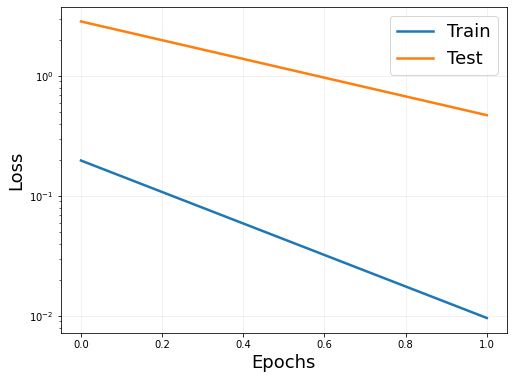

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [17]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 3.5366231919995568
L2 Error  of Temp: 0.37424112693388145


In [18]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.6045299968667817
L2 Error  of Temp: 0.06604599673999485


# Saving Model

In [19]:
PATH = f"./saved_models/direct_model_train_pb_time.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
data = data_df.values
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)
data_mean = scaler.mean_
data_std = scaler.scale_

In [35]:
model(torch.tensor(data_df[input_columns], dtype=torch.float)).detach().numpy()

ValueError: could not determine the shape of object type 'DataFrame'